<img src="http://oproject.org/tiki-download_file.php?fileId=8&display&x=450&y=128">
<img src="http://files.oproject.org/tmvalogo.png" height="50%" width="50%">

# TMVA Higgs Classification Example in Python

In this example we will still do Higgs classification but we will use together with the native TMVA methods also methods from Keras and scikit-learn.

In [1]:
import ROOT
from ROOT import TMVA

Welcome to JupyROOT 6.15/01


## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [2]:
ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Input Data

We define now the input data file and we retrieve the ROOT TTree objects with the signal and background input events

In [3]:
inputFileName = "Higgs_data.root"


inputFile = ROOT.TFile.Open( inputFileName )

# retrieve input trees

signalTree     = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")

signalTree.Print()

******************************************************************************
*Tree    :sig_tree  : Signal Tree                                            *
*Entries :    10000 : Total =         1141446 bytes  File  Size =    1000730 *
*        :          : Tree compression factor =   1.13                       *
******************************************************************************
*Br    0 :lepton_pT : lepton_pT/F                                            *
*Entries :    10000 : Total  Size=      40761 bytes  File Size  =      30836 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.04     *
*............................................................................*
*Br    1 :lepton_eta : lepton_eta/F                                          *
*Entries :    10000 : Total  Size=      40768 bytes  File Size  =      29658 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

#### 20-09-2018

RandomForest gave this feature importance

----------------------------------------------------------
                         : Rank : Variable                 : Variable Importance
                         : ----------------------------------------------------------
                         :    1 : m_bb                     : 2.860e-01
                         :    2 : m_wwbb                   : 1.369e-01
                         :    3 : m_wbb                    : 1.342e-01
                         :    4 : m_jjj                    : 7.804e-02
                         :    5 : jet1_pt                  : 6.941e-02
                         :    6 : m_jlv                    : 5.204e-02
                         :    7 : missing_energy_magnitude : 4.423e-02
                         :    8 : lepton_pT                : 3.328e-02
                         :    9 : jet2_pt                  : 2.727e-02
                         :   10 : m_jj                     : 1.993e-02
                         :   11 : jet3_pt                  : 1.385e-02
                         :   12 : jet4_pt                  : 1.184e-02
                         :   13 : m_lv                     : 8.750e-03
                         :   14 : jet1_eta                 : 8.208e-03
                         :   15 : jet3_eta                 : 7.907e-03
                         :   16 : jet2_eta                 : 7.382e-03
                         :   17 : lepton_eta               : 6.947e-03
                         :   18 : jet4_eta                 : 6.868e-03
                         :   19 : lepton_phi               : 6.351e-03
                         :   20 : jet2_phi                 : 6.343e-03
                         :   21 : missing_energy_phi       : 6.123e-03
                         :   22 : jet4_phi                 : 6.051e-03
                         :   23 : jet1_phi                 : 5.632e-03
                         :   24 : jet3_phi                 : 5.227e-03
                         :   25 : jet1_btag                : 4.854e-03
                         :   26 : jet3_btag                : 3.403e-03
                         :   27 : jet2_btag                : 1.537e-03
                         :   28 : jet4_btag                : 1.425e-03

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree,     signalWeight     )
loader.AddBackgroundTree( backgroundTree, backgroundWeight )

## Define input variables 

loader.AddVariable("m_jj")
loader.AddVariable("m_jjj")
loader.AddVariable("m_lv")
loader.AddVariable("m_jlv")
loader.AddVariable("m_bb")
loader.AddVariable("m_wbb")
loader.AddVariable("m_wwbb")


# select more variables
loader.AddVariable("jet1_pt")
# loader.AddVariable("jet1_eta")
# loader.AddVariable("jet1_phi")
# loader.AddVariable("jet1_btag")
loader.AddVariable("jet2_pt")
# loader.AddVariable("jet2_eta")
# loader.AddVariable("jet2_phi")
# loader.AddVariable("jet2_btag")
loader.AddVariable("jet3_pt")
# loader.AddVariable("jet3_eta")
# loader.AddVariable("jet3_phi")
# loader.AddVariable("jet3_btag")
loader.AddVariable("jet4_pt")
# loader.AddVariable("jet4_eta")
# loader.AddVariable("jet4_phi")
# loader.AddVariable("jet4_btag")
loader.AddVariable("lepton_pT")
# loader.AddVariable("lepton_eta")
# loader.AddVariable("lepton_phi")
loader.AddVariable("missing_energy_magnitude")
# loader.AddVariable("missing_energy_phi")

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.


In [5]:
##### ## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree( mycuts, mycutb,
                                  "nTrain_Signal=7000:nTrain_Background=7000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

# Booking Methods

Here we book the TMVA methods. We book a Likelihood based a BDT and a standard MLP (shallow NN)

In [6]:
# Linear discrimant analysis
factory.BookMethod(loader, ROOT.TMVA.Types.kLD, "LD", "H:!V:VarTransform=G,D")

<ROOT.TMVA::MethodLD object ("LD") at 0x7f80ee30ee00>

Factory                  : Booking method: LD
                         : 
LD                       : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
                         : Input : variable 'jet1_pt' <---> Output : variable 'jet1_pt'
                         : Input : variable 'jet2_pt' <---> Output

In [7]:
#xgboost
# factory.BookMethod(loader, ROOT.TMVA.Types.kRXGB, "XGB")#, "H:!V:VarTransform=G")

In [8]:
## Boosted Decision Trees
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                    "!V:NTrees=500:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                    "BaggedSampleFraction=0.25:SeparationType=GiniIndex:nCuts=20" )

## Multi-Layer Perceptron (Neural Network)
# factory.BookMethod(loader, ROOT.TMVA.Types.kMLP, "MLP",
#                    "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

<ROOT.TMVA::MethodBDT object ("BDT") at 0x7f80eaef6a00>

Factory                  : Booking method: BDT
                         : 


## Using scikit-learn

here we book some scikit learn packages

In [9]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyGTB, "PyGTB","H:!V:VarTransform=G:NEstimators=1000:LearningRate=0.1:"
                                                  "MaxDepth=6:MinSamplesLeaf=3")

# factory.BookMethod(loader, ROOT.TMVA.Types.kPyGTB, "PyGTBD","H:!V:VarTransform=D:NEstimators=400:LearningRate=0.1:"
#                                                   "MaxDepth=3")

factory.BookMethod(loader, ROOT.TMVA.Types.kPyRandomForest, "PyRandomForest","!V:VarTransform=G:NEstimators=400:"
                           "Criterion=gini:MaxFeatures=auto:MaxDepth=6:MinSamplesLeaf=3:MinWeightFractionLeaf=0:"
                            "Bootstrap=kTRUE" )

# factory.BookMethod(loader, ROOT.TMVA.Types.kPyRandomForest, "PyRandomForestD","!V:VarTransform=D:NEstimators=400:"
#                            "Criterion=gini:MaxFeatures=auto:MaxDepth=6:MinSamplesLeaf=3:MinWeightFractionLeaf=0:"
#                             "Bootstrap=kTRUE" )
      
# factory.BookMethod(loader, ROOT.TMVA.Types.kPyAdaBoost, "PyAdaBoost","!V:VarTransform=G:NEstimators=400" )

# factory.BookMethod(loader, ROOT.TMVA.Types.kPyAdaBoost, "PyAdaBoostD","!V:VarTransform=D:NEstimators=400" )

<ROOT.TMVA::MethodPyRandomForest object ("PyRandomForest") at 0x7f80ebe15800>

Factory                  : Booking method: PyGTB
                         : 
PyGTB                    : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
                         : Input : variable 'jet1_pt' <---> Output : variable 'jet1_pt'
                         : Input : variable 'jet2_pt' <---> Out

### Booking Deep Neural Network

Here we book the new DNN of TMVA. We use the new DL method available in TMVA

#### 1. Define DNN layout

we need to define (note the use of the character | as  separator of  input parameters) 

- input layout :   this defines the input data format for the DNN as  input depth | height | width. 
   In case of a dense layer as first layer the input layout should be  1 | 1 | number of input variables (features)
- batch layout  : this defines how are the input batch. It is related to input layout but not the same. 
   If the first layer is dense it should be 1 | batch size ! number of variables (fetures)
                 
- layout string defining the architecture. The syntax is  
   - layer type (e.g. DENSE, CONV, RNN)
   - layer parameters (e.g. number of units)
   - activation function (e.g  TANH, RELU,...)
   
     the different layers are separated by the "," 
                

In [10]:
inputLayoutString = "InputLayout=1|1|13"; 
batchLayoutString= "BatchLayout=1|32|13";
# layoutString = ("Layout=DENSE|64|RELU,DENSE|32|RELU, DENSE|32|RELU,DENSE|1|LINEAR")                                                                                                                                                          
layoutString = ("Layout=DENSE|64|TANH,DENSE|32|TANH,DENSE|32|TANH,DENSE|1|LINEAR");

#### 2. Define Trainining Strategy

We define here the different training strategy for the DNN. One can concatenate different training strategy changing parameters like: 
 - Optimizer
 - Learning rate
 - Momentum (valid for SGD and RMSPROP)
 - Regularization and Weight Decay 
 - Dropout 
 - Max number of epochs 
 - Convergence steps. if the test error will not decrease after that value the training will stop
 - Batch size (This value must be the same specified in the input layout)
 - Test Repetitions (the interval when the test error will be computed) 



In [11]:
##Training strategies 
## one can catenate several training strategies

training1  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,"
training1 += "DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
 
# we add regularization in the second phase
training2  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=L2,WeightDecay=1e-4,"
training2 += "DropConfig=0.0+0.0+0.0+0,MaxEpochs=20,ConvergenceSteps=10,BatchSize=1000,TestRepetitions=1"
     
            

trainingStrategyString = "TrainingStrategy=" + training1  #+ training2


#### 3. Define general options and book method

We define the general DNN options such as 

- Type of Loss function (e.g. cross entropy)
- Weight Initizalization (e.g XAVIER, XAVIERUNIFORM, NORMAL )
- Variable Transformation
- Type of Architecture (e.g. CPU, GPU, Standard)

We add then also all the other options defined before 

In [12]:
## General Options.                                                                                                                                                                
dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU"

dnnOptions +=  ":" + inputLayoutString
dnnOptions +=  ":" + batchLayoutString
dnnOptions +=  ":" + layoutString
dnnOptions +=  ":" + trainingStrategyString

In [13]:
#we can now book the method
              
factory.BookMethod(loader, ROOT.TMVA.Types.kDL, "DL_CPU", dnnOptions)

<ROOT.TMVA::MethodDL object ("DL_CPU") at 0x7f80efd4a800>

Factory                  : Booking method: DL_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1|1|13:BatchLayout=1|32|13:Layout=DENSE|64|TANH,DENSE|32|TANH,DENSE|32|TANH,DENSE|1|LINEAR:TrainingStrategy=Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1

In [14]:
## to use tensorflow backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [15]:
from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.
2018-09-21 14:25:10.836354: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [16]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh', input_dim=13))
model.add(Dropout(0.1))
model.add(Dense(32, kernel_initializer='glorot_normal', activation='tanh'))
# model.add(Dropout(0.1))
# model.add(Dense(32, kernel_initializer='glorot_normal', activation='tanh'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense13_2109_v2.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 3,042
Trainable params: 3,042
Non-trainable params: 0
_________________________________________________________________


In [17]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense13',
        'H:!V:VarTransform=G:FilenameModel=model_dense13_2109_v2.h5:'+\
        'NumEpochs=50:BatchSize=32:TriesEarlyStopping=10')

# factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_DenseD',
#         'H:!V:VarTransform=D:FilenameModel=model_dense.h5:'+\
#         'NumEpochs=30:BatchSize=64:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense13") at 0x7f80ebd5d800>

Factory                  : Booking method: Keras_Dense13
                         : 
Keras_Dense13            : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
                         : Input : variable 'jet1_pt' <---> Output : variable 'jet1_pt'
                         : Input : variable 'jet2_pt' <

## Train Methods

In [18]:
factory.TrainAllMethods();

Train on 14000 samples, validate on 6000 samples
Epoch 1/50
14000/14000 [==============================] - 1s 83us/step - loss: 0.6646 - categorical_accuracy: 0.5969 - val_loss: 0.6381 - val_categorical_accuracy: 0.6382
Epoch 2/50
14000/14000 [==============================] - 1s 45us/step - loss: 0.6370 - categorical_accuracy: 0.6416 - val_loss: 0.6184 - val_categorical_accuracy: 0.6592
Epoch 3/50
14000/14000 [==============================] - 1s 44us/step - loss: 0.6131 - categorical_accuracy: 0.6591 - val_loss: 0.5889 - val_categorical_accuracy: 0.6882
Epoch 4/50
14000/14000 [==============================] - 1s 47us/step - loss: 0.5876 - categorical_accuracy: 0.6870 - val_loss: 0.5786 - val_categorical_accuracy: 0.6992
Epoch 5/50
14000/14000 [==============================] - 1s 46us/step - loss: 0.5779 - categorical_accuracy: 0.6961 - val_loss: 0.5683 - val_categorical_accuracy: 0.6993
Epoch 6/50
14000/14000 [==============================] - 1s 49us/step - loss: 0.5688 - categori

## Test  all methods

Here we test all methods using the test data set

In [19]:
factory.TestAllMethods();   

Factory                  : Test all methods
Factory                  : Test method: LD for Classification performance
                         : 
LD                       : [dataset] : Evaluation of LD on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0506 sec       
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.116 sec       
Factory                  : Test method: PyGTB for Classification performance
                         : 
                         : 
                         : Loading state file: dataset/weights/PyGTBModel_PyGTB.PyData
                         : 
PyGTB                    : [dataset] : Evaluation of PyGTB on testing sample (6000 events)
                         : Elapsed time for evaluation of 

## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [20]:
factory.EvaluateAllMethods();

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: LD
                         : 
TFHandler_LD             :                 Variable                        Mean                        RMS                [        Min                        Max ]
                         : -------------------------------------------------------------------------------------------------------------------------------------------
                         :                     m_jj:                 -0.026478                   0.99976   [                   -6.4672                    4.6249 ]
                         :                    m_jjj:               -0.00053943                   0.99101   [                   -3.7286                    3.6493 ]
                         :                     m_lv:                 -0.010609                    1.0005   [                   -5.3758                    5.4840 ]
                         :                    m_jlv: 

## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [24]:
%jsroot on

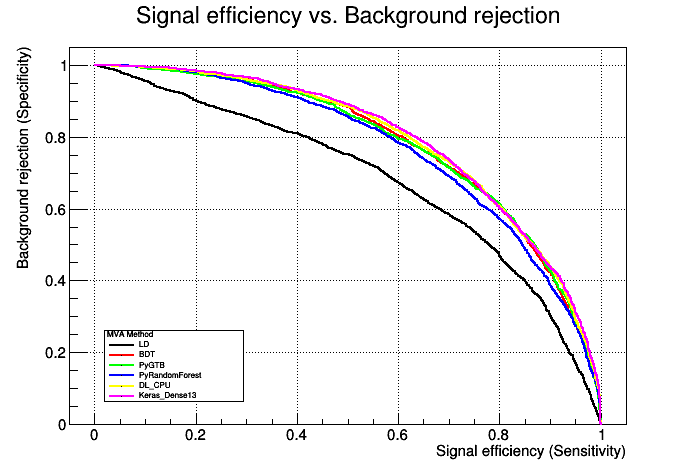

In [21]:
c1 = factory.GetROCCurve(loader);
c1.Draw();


####  Close outputfile to save all output information (evaluation result of methods)

In [26]:
outputFile.Close();